# Sports Tournament Scheduler - Genetic Algorithm

This notebook implements a complete Sports Tournament Scheduling system using a Genetic Algorithm.

## Project Structure
- All code is contained in this single notebook
- Code runs sequentially from top to bottom
- GUI can be launched directly from a notebook cell


## Cell 1: Imports and Global Settings


In [ ]:
import random
import copy
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import ttk, scrolledtext, messagebox
import threading
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, HBox, VBox, Output
from IPython.display import display, clear_output

# Set matplotlib backend for notebook
%matplotlib inline


## Cell 2: Data Definitions
 

In [26]:
# Teams list
TEAMS = [
    "Al Ahly", "Zamalek", "Pyramids", "Masry", "Future", "Ismaily",
    "Smouha", "ENPPI", "Ceramica", "National Bank", "Talaea El Gaish",
    "Alexandria Union", "El Dakhleya", "El Gouna", "Zed",
    "Modern Sport", "Pharco", "Wadi Degla"
]

# Venues list
VENUES = [
    "Cairo Stadium", "Borg El Arab", "Air Defense Stadium",
    "Suez Stadium", "Alexandria Stadium", "Petro Sport Stadium",
    "Military Academy Stadium", "Al Salam Stadium",
    "El Sekka El Hadeed Stadium", "Zed Club Stadium"
]

# Match times
MATCH_TIMES = ["17:00", "20:00"]

# Generate dates
def generate_dates(start_date=None, end_date=None):
    """Generate list of available dates for the tournament"""
    if start_date is None:
        start_date = datetime(2025, 5, 1)
    if end_date is None:
        end_date = datetime(2026, 1, 31)
    
    dates = []
    current = start_date
    while current <= end_date:
        dates.append(current)
        current += timedelta(days=1)
    return dates

# Generate dates
DATES = generate_dates()


## Cell 3: Match Class


In [27]:
class Match:
    """Represents a single match in the tournament schedule"""
    
    def __init__(self, team1, team2, date, time, venue, leg):
        self.team1 = team1
        self.team2 = team2
        self.date = date
        self.time = time
        self.venue = venue
        self.leg = leg

    def __repr__(self):
        return f"{self.team1} vs {self.team2} (leg {self.leg}) on {self.date.strftime('%Y-%m-%d')} {self.time} at {self.venue}"
    
    def __eq__(self, other):
        if not isinstance(other, Match):
            return False
        return (self.team1 == other.team1 and 
                self.team2 == other.team2 and 
                self.leg == other.leg)
    
    def __hash__(self):
        return hash((self.team1, self.team2, self.leg))


## Cell 4: Encoding & Population Initialization


In [28]:
def generate_all_matches(teams):
    """Generate all possible matches (home & away) for the tournament"""
    matches = []
    for i in range(len(teams)):
        for j in range(i + 1, len(teams)):
            matches.append((teams[i], teams[j], 1))  # Leg 1
            matches.append((teams[j], teams[i], 2))  # Leg 2
    return matches


def create_random_individual(teams, venues, dates, match_times):
    """Create a random chromosome (individual) representing a full schedule"""
    chromosome = []
    all_matches = generate_all_matches(teams)
    random.shuffle(all_matches)

    for team1, team2, leg in all_matches:
        chromosome.append(
            Match(
                team1,
                team2,
                random.choice(dates),
                random.choice(match_times),
                random.choice(venues),
                leg
            )
        )
    return chromosome


def create_initial_population(pop_size, teams, venues, dates, match_times):
    """Create initial population of random individuals"""
    population = []
    for _ in range(pop_size):
        population.append(
            create_random_individual(teams, venues, dates, match_times)
        )
    return population


## Cell 5: Fitness Function


In [29]:
def fitness(individual):
    """
    Calculate fitness of an individual (schedule).
    
    Fitness = 1 / (1 + total_penalty)
    
    Penalties:
    - Venue Conflicts (weight 5): Same venue + same date + same time
    - Rest Period Violations (weight 3): Team playing with less than 1 day rest
    - Match Time Balance (weight 1): Uneven distribution between 17:00 and 20:00
    """
    penalty = 0

    # 1. Venue Conflicts (weight 5)
    venue_time_dict = {}
    for match in individual:
        key = (match.date, match.time, match.venue)
        if key in venue_time_dict:
            penalty += 5
        else:
            venue_time_dict[key] = match

    # 2. Rest periods (weight 3)
    team_dates = {}
    for match in individual:
        for team in [match.team1, match.team2]:
            if team not in team_dates:
                team_dates[team] = []
            team_dates[team].append(match.date)

    for dates in team_dates.values():
        dates.sort()
        for i in range(1, len(dates)):
            if (dates[i] - dates[i-1]).days < 1:
                penalty += 3

    # 3. Balance game times (weight 1)
    team_time_count = {team: {"17:00": 0, "20:00": 0} for team in team_dates}
    for match in individual:
        team_time_count[match.team1][match.time] += 1
        team_time_count[match.team2][match.time] += 1

    for counts in team_time_count.values():
        penalty += abs(counts["17:00"] - counts["20:00"]) * 1

    # Final fitness (higher is better)
    return 1 / (1 + penalty)


def calculate_penalty_breakdown(individual):
    """
    Calculate detailed penalty breakdown for analysis.
    Returns dict with individual penalty components.
    """
    venue_conflicts = 0
    rest_violations = 0
    time_imbalance = 0
    
    # 1. Venue Conflicts
    venue_time_dict = {}
    for match in individual:
        key = (match.date, match.time, match.venue)
        if key in venue_time_dict:
            venue_conflicts += 1
        else:
            venue_time_dict[key] = match

    # 2. Rest periods
    team_dates = defaultdict(list)
    for match in individual:
        team_dates[match.team1].append(match.date)
        team_dates[match.team2].append(match.date)

    for dates_list in team_dates.values():
        dates_list.sort()
        for i in range(1, len(dates_list)):
            if (dates_list[i] - dates_list[i-1]).days < 1:
                rest_violations += 1

    # 3. Time balance
    team_time_count = {team: {"17:00": 0, "20:00": 0} for team in team_dates}
    for match in individual:
        team_time_count[match.team1][match.time] += 1
        team_time_count[match.team2][match.time] += 1

    for counts in team_time_count.values():
        time_imbalance += abs(counts["17:00"] - counts["20:00"])
    
    total_penalty = venue_conflicts * 5 + rest_violations * 3 + time_imbalance
    
    return {
        'venue_conflicts': venue_conflicts,
        'rest_violations': rest_violations,
        'time_imbalance': time_imbalance,
        'total_penalty': total_penalty,
        'fitness': 1 / (1 + total_penalty)
    }


## Cell 6: Selection Methods


In [30]:
def tournament_selection(population, fitness_scores, k=3):
    """
    Tournament selection: Select k individuals randomly and return the best.
    Balances exploration and exploitation.
    """
    selected = random.sample(list(zip(population, fitness_scores)), k)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]


def roulette_wheel_selection(population, fitness_scores):
    """
    Roulette wheel selection: Select individual proportionally to fitness.
    Higher fitness = higher probability of selection.
    """
    total_fitness = sum(fitness_scores)
    pick = random.uniform(0, total_fitness)
    current = 0
    for ind, fit in zip(population, fitness_scores):
        current += fit
        if current > pick:
            return ind
    return population[-1]  # Fallback


## Cell 7: Crossover Methods


In [31]:
def one_point_crossover(parent1, parent2):
    """
    One-point crossover: Exchange segments at a random point.
    """
    point = random.randint(1, len(parent1) - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2


def two_point_crossover(parent1, parent2):
    """
    Two-point crossover: Swap a continuous block between two points.
    Allows larger structural changes in schedules.
    """
    p1 = random.randint(1, len(parent1) - 3)
    p2 = random.randint(p1 + 1, len(parent1) - 2)

    child1 = parent1[:p1] + parent2[p1:p2] + parent1[p2:]
    child2 = parent2[:p1] + parent1[p1:p2] + parent2[p2:]

    return child1, child2


def order_crossover(parent1, parent2):
    """
    Order crossover (OX): Preserves relative order of genes.
    Useful for permutation-based representations.
    """
    size = len(parent1)
    p1 = random.randint(0, size - 2)
    p2 = random.randint(p1 + 1, size - 1)

    child = [None] * size
    child[p1:p2] = parent1[p1:p2]

    p2_genes = [gene for gene in parent2 if gene not in child]

    idx = 0
    for i in range(size):
        if child[i] is None:
            child[i] = p2_genes[idx]
            idx += 1

    return child


## Cell 8: Mutation Methods


In [32]:
def swap_mutation(individual):
    """
    Swap mutation: Exchange two randomly selected genes.
    Introduces small local changes while preserving feasibility.
    """
    i, j = random.sample(range(len(individual)), 2)
    individual[i], individual[j] = individual[j], individual[i]


def inversion_mutation(individual):
    """
    Inversion mutation: Reverse the order of a segment.
    Helps escape local optima by restructuring match order.
    """
    i, j = sorted(random.sample(range(len(individual)), 2))
    individual[i:j] = reversed(individual[i:j])


def scramble_mutation(individual):
    """
    Scramble mutation: Randomly shuffle a segment.
    Introduces more randomness than swap or inversion.
    """
    i, j = sorted(random.sample(range(len(individual)), 2))
    subset = individual[i:j]
    random.shuffle(subset)
    individual[i:j] = subset


def apply_mutation(individual, mutation_rate=0.1, method="swap"):
    """
    Apply mutation to individual based on mutation rate and method.
    """
    if random.random() > mutation_rate:
        return

    if method == "swap":
        swap_mutation(individual)
    elif method == "inversion":
        inversion_mutation(individual)
    elif method == "scramble":
        scramble_mutation(individual)


## Cell 9: Genetic Algorithm Function


In [33]:
def genetic_algorithm(teams, venues, dates, match_times,
                      pop_size=50, generations=100,
                      crossover_rate=0.8, mutation_rate=0.1,
                      elitism_count=2, tournament_size=3,
                      crossover_method="two_point",
                      mutation_method="swap",
                      selection_method="tournament",
                      callback=None,
                      convergence_epsilon=1e-6,
                      convergence_generations=10,
                      no_improvement_patience=20):
    """
    Main Genetic Algorithm function with multiple termination criteria.
    
    Parameters:
    -----------
    teams : list - List of team names
    venues : list - List of venue names
    dates : list - List of available dates
    match_times : list - List of match times (e.g., ["17:00", "20:00"])
    pop_size : int - Population size
    generations : int - Maximum number of generations (TERMINATION CRITERION 1)
    crossover_rate : float - Probability of crossover (0.0-1.0)
    mutation_rate : float - Probability of mutation (0.0-1.0)
    elitism_count : int - Number of elite individuals to preserve
    tournament_size : int - Size of tournament for selection
    crossover_method : str - "one_point", "two_point", or "order"
    mutation_method : str - "swap", "inversion", or "scramble"
    selection_method : str - "tournament" or "roulette"
    callback : function - Optional callback for progress updates
    convergence_epsilon : float - Tolerance for fitness convergence (TERMINATION CRITERION 2)
    convergence_generations : int - Number of consecutive generations for convergence check
    no_improvement_patience : int - Max generations without improvement (TERMINATION CRITERION 3)
    
    Returns:
    --------
    dict with keys:
        - best_individual: Best schedule found
        - best_fitness: Fitness of best schedule
        - best_fitness_history: List of best fitness per generation
        - avg_fitness_history: List of average fitness per generation
        - worst_fitness_history: List of worst fitness per generation
        - termination_reason: Reason for termination
        - final_generation: Generation at which algorithm stopped
    """
    print(f"\n{'='*60}")
    print("🧬 GENETIC ALGORITHM STARTED")
    print(f"{'='*60}")
    print(f"Termination Criteria:")
    print(f"  - Max Generations: {generations}")
    print(f"  - Convergence Epsilon: {convergence_epsilon}")
    print(f"  - Convergence Generations: {convergence_generations}")
    print(f"  - No Improvement Patience: {no_improvement_patience}")
    print(f"{'='*60}")

    # Create initial population
    population = create_initial_population(pop_size, teams, venues, dates, match_times)

    # History tracking
    best_fitness_history = []
    avg_fitness_history = []
    worst_fitness_history = []
    best_individual = None
    best_fitness = 0
    
    # ================= TERMINATION CRITERIA TRACKING =================
    # TERMINATION CRITERION 1: Maximum Generations (already handled by loop)
    
    # TERMINATION CRITERION 2: Fitness Convergence
    # Track consecutive generations with minimal fitness change
    convergence_counter = 0
    previous_best_fitness = None
    
    # TERMINATION CRITERION 3: No Improvement Threshold
    # Track consecutive generations without improvement
    no_improvement_counter = 0
    
    termination_reason = "Maximum generations reached"
    final_generation = generations

    # Evolution loop
    for gen in range(generations):
        # Calculate fitness for all individuals
        fitness_scores = [fitness(ind) for ind in population]

        gen_best = max(fitness_scores)
        gen_avg = sum(fitness_scores) / len(fitness_scores)
        gen_worst = min(fitness_scores)

        best_fitness_history.append(gen_best)
        avg_fitness_history.append(gen_avg)
        worst_fitness_history.append(gen_worst)

        # Track best individual and check for improvement
        improvement_made = False
        if gen_best > best_fitness:
            best_fitness = gen_best
            best_individual = copy.deepcopy(
                population[fitness_scores.index(gen_best)]
            )
            improvement_made = True
            no_improvement_counter = 0  # Reset counter on improvement
        else:
            no_improvement_counter += 1

        # ================= TERMINATION CRITERION 2: FITNESS CONVERGENCE =================
        # Check if fitness has converged (minimal change over consecutive generations)
        if previous_best_fitness is not None:
            fitness_change = abs(gen_best - previous_best_fitness)
            if fitness_change < convergence_epsilon:
                convergence_counter += 1
            else:
                convergence_counter = 0  # Reset if fitness changes significantly
        else:
            convergence_counter = 0
        
        previous_best_fitness = gen_best
        
        # Check convergence termination
        if convergence_counter >= convergence_generations:
            termination_reason = f"Fitness converged (no significant change for {convergence_generations} generations)"
            final_generation = gen + 1
            print(f"\n{'='*60}")
            print(f"🛑 EARLY TERMINATION: {termination_reason}")
            print(f"   Stopped at generation {final_generation}")
            print(f"   Best fitness: {best_fitness:.6f}")
            print(f"   Fitness change: {fitness_change:.2e} < epsilon: {convergence_epsilon}")
            print(f"{'='*60}\n")
            break
        
        # ================= TERMINATION CRITERION 3: NO IMPROVEMENT THRESHOLD =================
        # Check if no improvement for too many generations
        if no_improvement_counter >= no_improvement_patience:
            termination_reason = f"No improvement for {no_improvement_patience} consecutive generations"
            final_generation = gen + 1
            print(f"\n{'='*60}")
            print(f"🛑 EARLY TERMINATION: {termination_reason}")
            print(f"   Stopped at generation {final_generation}")
            print(f"   Best fitness: {best_fitness:.6f}")
            print(f"{'='*60}\n")
            break

        # Progress output
        if gen % 10 == 0 or gen == generations - 1:
            print(f"Gen {gen:3d} | Best: {gen_best:.6f} | Avg: {gen_avg:.6f} | "
                  f"NoImp: {no_improvement_counter}/{no_improvement_patience} | "
                  f"Conv: {convergence_counter}/{convergence_generations}")
            
        # Callback for GUI updates
        if callback:
            callback(gen, generations, gen_best, gen_avg)

        # ================= ELITISM =================
        elite_idx = sorted(
            range(len(fitness_scores)),
            key=lambda i: fitness_scores[i],
            reverse=True
        )[:elitism_count]

        new_population = [copy.deepcopy(population[i]) for i in elite_idx]

        # ================= CREATE OFFSPRING =================
        while len(new_population) < pop_size:

            # -------- Parent Selection --------
            if selection_method == "tournament":
                p1 = tournament_selection(population, fitness_scores, tournament_size)
                p2 = tournament_selection(population, fitness_scores, tournament_size)
            else:  # roulette
                p1 = roulette_wheel_selection(population, fitness_scores)
                p2 = roulette_wheel_selection(population, fitness_scores)

            # -------- Crossover --------
            if random.random() < crossover_rate:
                if crossover_method == "one_point":
                    c1, c2 = one_point_crossover(copy.deepcopy(p1), copy.deepcopy(p2))
                elif crossover_method == "two_point":
                    c1, c2 = two_point_crossover(copy.deepcopy(p1), copy.deepcopy(p2))
                else:  # order crossover
                    c1 = order_crossover(copy.deepcopy(p1), copy.deepcopy(p2))
                    c2 = order_crossover(copy.deepcopy(p2), copy.deepcopy(p1))
            else:
                c1, c2 = copy.deepcopy(p1), copy.deepcopy(p2)

            # -------- Mutation --------
            apply_mutation(c1, mutation_rate, mutation_method)
            apply_mutation(c2, mutation_rate, mutation_method)

            new_population.append(c1)
            if len(new_population) < pop_size:
                new_population.append(c2)

        population = new_population

    # ================= TERMINATION CRITERION 1: MAXIMUM GENERATIONS =================
    # If we reach here, maximum generations was reached
    if final_generation == generations:
        print(f"\n{'='*60}")
        print("✅ EVOLUTION COMPLETED")
        print(f"🏆 Best Fitness: {best_fitness:.6f}")
        print(f"📊 Termination: {termination_reason}")
        print(f"{'='*60}\n")

    return {
        'best_individual': best_individual,
        'best_fitness': best_fitness,
        'best_fitness_history': best_fitness_history,
        'avg_fitness_history': avg_fitness_history,
        'worst_fitness_history': worst_fitness_history,
        'termination_reason': termination_reason,
        'final_generation': final_generation
    }


## Termination Criteria Discussion

The genetic algorithm implements three termination criteria to balance solution quality and computational efficiency:

### 1. Maximum Generations Termination

The algorithm stops when a predefined maximum number of generations is reached. This criterion ensures a bounded runtime and prevents the algorithm from running indefinitely. It provides a predictable upper limit on execution time, which is essential for practical applications where time constraints exist. However, this criterion alone may result in premature termination if the algorithm is still improving, or unnecessary computation if convergence occurs early.

### 2. Fitness Convergence (Alternative Termination Criterion)

Fitness convergence detects when the algorithm stabilizes and further evolution produces negligible improvements. This is implemented by tracking the absolute difference between best fitness values over consecutive generations. If the fitness change remains below a small tolerance (epsilon) for a fixed number of consecutive generations, the algorithm terminates early. This criterion is useful because it identifies when the population has reached a stable state where additional generations are unlikely to yield significant improvements, thus saving computational resources while ensuring the solution quality is satisfactory.

### 3. No Improvement Threshold (Alternative Termination Criterion)

The no-improvement threshold stops the algorithm if the best fitness does not improve for a predefined number of consecutive generations (patience value). This criterion helps avoid unnecessary computation when the algorithm has reached a plateau and is no longer making progress. Unlike convergence, which checks for minimal change, this criterion specifically tracks the absence of any improvement, making it effective for detecting when the algorithm is stuck in a local optimum or has exhausted its search capability. This prevents wasting computational resources on generations that do not contribute to finding better solutions.

### Why These Criteria Work Together

The combination of these three termination criteria provides a robust stopping mechanism:
- **Maximum generations** ensures the algorithm always terminates within a reasonable time frame
- **Fitness convergence** allows early termination when the solution has stabilized
- **No improvement threshold** prevents wasted computation when the algorithm plateaus

Together, they balance the trade-off between solution quality and computational efficiency, ensuring the algorithm stops when further evolution is unlikely to be beneficial.


In [34]:
def plot_fitness_evolution(results, title="GA Fitness Evolution"):
    """
    Plot fitness evolution over generations
    Shows Best, Average, and Worst fitness
    """
    plt.figure(figsize=(14, 7))
    
    generations = range(len(results['best_fitness_history']))
    
    # Plot lines
    plt.plot(generations, results['best_fitness_history'], 
             'g-', linewidth=2.5, label='Best Fitness', marker='o', markersize=3)
    plt.plot(generations, results['avg_fitness_history'], 
             'b--', linewidth=2, label='Average Fitness', marker='s', markersize=2)
    plt.plot(generations, results['worst_fitness_history'], 
             'r:', linewidth=1.5, label='Worst Fitness', marker='^', markersize=2)
    
    # Fill area between best and worst
    plt.fill_between(generations, 
                     results['worst_fitness_history'],
                     results['best_fitness_history'],
                     alpha=0.2, color='blue', label='Fitness Range')
    
    # Styling
    plt.xlabel('Generation', fontsize=13, fontweight='bold')
    plt.ylabel('Fitness Value', fontsize=13, fontweight='bold')
    plt.title(title, fontsize=15, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add improvement annotation
    improvement = ((results['best_fitness_history'][-1] - results['best_fitness_history'][0]) 
                   / results['best_fitness_history'][0] * 100)
    plt.text(0.5, 0.95, f'Improvement: {improvement:.1f}%', 
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             fontsize=11, verticalalignment='top', horizontalalignment='center')
    
    plt.tight_layout()
    plt.show()


def plot_penalty_evolution(results, title="Penalty Reduction Over Time"):
    """
    Plot penalty reduction (inverse of fitness)
    """
    plt.figure(figsize=(14, 7))
    
    generations = range(len(results['best_fitness_history']))
    
    # Convert fitness to penalty
    best_penalty = [1/f - 1 for f in results['best_fitness_history']]
    avg_penalty = [1/f - 1 for f in results['avg_fitness_history']]
    worst_penalty = [1/f - 1 for f in results['worst_fitness_history']]
    
    plt.plot(generations, best_penalty, 
             'g-', linewidth=2.5, label='Best (Lowest Penalty)', marker='o', markersize=3)
    plt.plot(generations, avg_penalty, 
             'b--', linewidth=2, label='Average Penalty', marker='s', markersize=2)
    plt.plot(generations, worst_penalty, 
             'r:', linewidth=1.5, label='Worst (Highest Penalty)', marker='^', markersize=2)
    
    plt.xlabel('Generation', fontsize=13, fontweight='bold')
    plt.ylabel('Total Penalty', fontsize=13, fontweight='bold')
    plt.title(title, fontsize=15, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add reduction annotation
    reduction = ((worst_penalty[0] - best_penalty[-1]) / worst_penalty[0] * 100)
    plt.text(0.5, 0.95, f'Penalty Reduction: {reduction:.1f}%', 
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
             fontsize=11, verticalalignment='top', horizontalalignment='center')
    
    plt.tight_layout()
    plt.show()


def analyze_constraints(individual, teams):
    """
    Detailed constraint analysis
    Returns breakdown of penalties
    """
    print("\n" + "="*70)
    print("📊 DETAILED CONSTRAINT ANALYSIS")
    print("="*70)
    
    # 1. Venue conflicts
    venue_time_dict = {}
    venue_conflicts = 0
    conflict_details = []
    
    for match in individual:
        key = (match.date, match.time, match.venue)
        if key in venue_time_dict:
            venue_conflicts += 1
            conflict_details.append((match, venue_time_dict[key]))
        else:
            venue_time_dict[key] = match
    
    print(f"\n🏟️  VENUE CONFLICTS: {venue_conflicts}")
    print(f"   Penalty: {venue_conflicts * 5}")
    if venue_conflicts > 0 and venue_conflicts <= 3:
        print("   Examples:")
        for i, (m1, m2) in enumerate(conflict_details[:3], 1):
            print(f"   {i}. {m1.venue} on {m1.date.strftime('%Y-%m-%d')} at {m1.time}")
            print(f"      - {m1.team1} vs {m1.team2}")
            print(f"      - {m2.team1} vs {m2.team2}")
    
    # 2. Rest period violations
    team_dates = defaultdict(list)
    for match in individual:
        team_dates[match.team1].append(match.date)
        team_dates[match.team2].append(match.date)
    
    rest_violations = 0
    rest_violations_by_team = {}
    
    for team, dates_list in team_dates.items():
        dates_list.sort()
        team_violations = 0
        for i in range(1, len(dates_list)):
            days_rest = (dates_list[i] - dates_list[i-1]).days
            if days_rest < 1:
                rest_violations += 1
                team_violations += 1
        if team_violations > 0:
            rest_violations_by_team[team] = team_violations
    
    print(f"\n😴 REST PERIOD VIOLATIONS: {rest_violations}")
    print(f"   Penalty: {rest_violations * 3}")
    print(f"   Teams affected: {len(rest_violations_by_team)}/{len(teams)}")
    if rest_violations_by_team:
        worst_teams = sorted(rest_violations_by_team.items(), 
                           key=lambda x: x[1], reverse=True)[:5]
        print("   Worst 5 teams:")
        for team, count in worst_teams:
            print(f"   - {team}: {count} violations")
    
    # 3. Time balance
    team_time_count = {team: {"17:00": 0, "20:00": 0} for team in teams}
    for match in individual:
        team_time_count[match.team1][match.time] += 1
        team_time_count[match.team2][match.time] += 1
    
    total_imbalance = 0
    imbalanced_teams = {}
    
    for team, counts in team_time_count.items():
        imbalance = abs(counts["17:00"] - counts["20:00"])
        total_imbalance += imbalance
        if imbalance > 0:
            imbalanced_teams[team] = (counts["17:00"], counts["20:00"], imbalance)
    
    print(f"\n⏰ TIME IMBALANCE: {total_imbalance}")
    print(f"   Penalty: {total_imbalance * 1}")
    if imbalanced_teams:
        worst_imbalance = sorted(imbalanced_teams.items(), 
                                key=lambda x: x[1][2], reverse=True)[:5]
        print("   Worst 5 teams:")
        for team, (early, late, imb) in worst_imbalance:
            print(f"   - {team}: {early} early vs {late} late (diff: {imb})")
    
    # Total
    total_penalty = venue_conflicts * 5 + rest_violations * 3 + total_imbalance
    fitness_val = 1 / (1 + total_penalty)
    
    print(f"\n" + "="*70)
    print(f"💰 TOTAL PENALTY: {total_penalty}")
    print(f"🎯 FITNESS VALUE: {fitness_val:.6f}")
    print("="*70)
    
    return {
        'venue_conflicts': venue_conflicts,
        'rest_violations': rest_violations,
        'time_imbalance': total_imbalance,
        'total_penalty': total_penalty,
        'fitness': fitness_val
    }


def plot_constraint_breakdown(constraint_data):
    """
    Pie chart showing penalty breakdown
    """
    venue_penalty = constraint_data['venue_conflicts'] * 5
    rest_penalty = constraint_data['rest_violations'] * 3
    time_penalty = constraint_data['time_imbalance'] * 1
    
    labels = ['Venue Conflicts', 'Rest Violations', 'Time Imbalance']
    sizes = [venue_penalty, rest_penalty, time_penalty]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    explode = (0.1, 0.05, 0)
    
    plt.figure(figsize=(10, 7))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('Penalty Distribution by Constraint Type', 
             fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


In [35]:
class TournamentSchedulerGUI:
    def __init__(self, root, ga_function, teams, venues, dates, match_times):
        self.root = root
        self.ga_function = ga_function
        self.teams = teams
        self.venues = venues
        self.dates = dates
        self.match_times = match_times
        self.results = None
        
        self.root.title("🏆 Sports Tournament Scheduler - Genetic Algorithm")
        self.root.geometry("900x700")
        self.root.configure(bg='#f0f0f0')
        
        self.setup_gui()
    
    def setup_gui(self):
        """Setup GUI components"""
        
        # Title
        title_frame = tk.Frame(self.root, bg='#2c3e50', height=80)
        title_frame.pack(fill='x')
        title_frame.pack_propagate(False)
        
        title_label = tk.Label(
            title_frame,
            text="🏆 SPORTS TOURNAMENT SCHEDULER",
            font=('Arial', 20, 'bold'),
            bg='#2c3e50',
            fg='white'
        )
        title_label.pack(expand=True)
        
        subtitle_label = tk.Label(
            title_frame,
            text="Using Genetic Algorithm Optimization",
            font=('Arial', 12),
            bg='#2c3e50',
            fg='#ecf0f1'
        )
        subtitle_label.pack()
        
        # Main container
        main_container = tk.Frame(self.root, bg='#f0f0f0')
        main_container.pack(fill='both', expand=True, padx=20, pady=20)
        
        # Left panel - Parameters
        left_panel = tk.LabelFrame(
            main_container,
            text="⚙️ GA Parameters",
            font=('Arial', 12, 'bold'),
            bg='white',
            padx=15,
            pady=15
        )
        left_panel.grid(row=0, column=0, sticky='nsew', padx=(0, 10))
        
        # Right panel - Output
        right_panel = tk.LabelFrame(
            main_container,
            text="📊 Output & Results",
            font=('Arial', 12, 'bold'),
            bg='white',
            padx=15,
            pady=15
        )
        right_panel.grid(row=0, column=1, sticky='nsew')
        
        main_container.columnconfigure(0, weight=1)
        main_container.columnconfigure(1, weight=2)
        main_container.rowconfigure(0, weight=1)
        
        # ===== LEFT PANEL - Parameters =====
        row = 0
        
        # Population Size
        tk.Label(left_panel, text="Population Size:", 
                font=('Arial', 10), bg='white').grid(row=row, column=0, sticky='w', pady=5)
        self.pop_size_var = tk.IntVar(value=30)
        pop_size_spin = tk.Spinbox(left_panel, from_=10, to=200, 
                                   textvariable=self.pop_size_var, width=15)
        pop_size_spin.grid(row=row, column=1, pady=5)
        row += 1
        
        # Generations
        tk.Label(left_panel, text="Generations:", 
                font=('Arial', 10), bg='white').grid(row=row, column=0, sticky='w', pady=5)
        self.gen_var = tk.IntVar(value=50)
        gen_spin = tk.Spinbox(left_panel, from_=10, to=500, 
                             textvariable=self.gen_var, width=15)
        gen_spin.grid(row=row, column=1, pady=5)
        row += 1
        
        # Crossover Rate
        tk.Label(left_panel, text="Crossover Rate:", 
                font=('Arial', 10), bg='white').grid(row=row, column=0, sticky='w', pady=5)
        self.crossover_rate_var = tk.DoubleVar(value=0.8)
        crossover_spin = tk.Spinbox(left_panel, from_=0.0, to=1.0, increment=0.1,
                                   textvariable=self.crossover_rate_var, width=15)
        crossover_spin.grid(row=row, column=1, pady=5)
        row += 1
        
        # Mutation Rate
        tk.Label(left_panel, text="Mutation Rate:", 
                font=('Arial', 10), bg='white').grid(row=row, column=0, sticky='w', pady=5)
        self.mutation_rate_var = tk.DoubleVar(value=0.1)
        mutation_spin = tk.Spinbox(left_panel, from_=0.0, to=1.0, increment=0.01,
                                  textvariable=self.mutation_rate_var, width=15)
        mutation_spin.grid(row=row, column=1, pady=5)
        row += 1
        
        # Elitism Count
        tk.Label(left_panel, text="Elitism Count:", 
                font=('Arial', 10), bg='white').grid(row=row, column=0, sticky='w', pady=5)
        self.elitism_var = tk.IntVar(value=2)
        elitism_spin = tk.Spinbox(left_panel, from_=0, to=20, 
                                 textvariable=self.elitism_var, width=15)
        elitism_spin.grid(row=row, column=1, pady=5)
        row += 1
        
        # Tournament Size
        tk.Label(left_panel, text="Tournament Size:", 
                font=('Arial', 10), bg='white').grid(row=row, column=0, sticky='w', pady=5)
        self.tournament_var = tk.IntVar(value=3)
        tournament_spin = tk.Spinbox(left_panel, from_=2, to=10, 
                                    textvariable=self.tournament_var, width=15)
        tournament_spin.grid(row=row, column=1, pady=5)
        row += 1
        
        # Crossover Method
        tk.Label(left_panel, text="Crossover Method:", 
                font=('Arial', 10), bg='white').grid(row=row, column=0, sticky='w', pady=5)
        self.crossover_method_var = tk.StringVar(value="two_point")
        crossover_combo = ttk.Combobox(left_panel, textvariable=self.crossover_method_var,
                                      values=["one_point", "two_point", "order"],
                                      state='readonly', width=13)
        crossover_combo.grid(row=row, column=1, pady=5)
        row += 1
        
        # Mutation Method
        tk.Label(left_panel, text="Mutation Method:", 
                font=('Arial', 10), bg='white').grid(row=row, column=0, sticky='w', pady=5)
        self.mutation_method_var = tk.StringVar(value="swap")
        mutation_combo = ttk.Combobox(left_panel, textvariable=self.mutation_method_var,
                                     values=["swap", "inversion", "scramble"],
                                     state='readonly', width=13)
        mutation_combo.grid(row=row, column=1, pady=5)
        row += 1
        
        # Separator
        ttk.Separator(left_panel, orient='horizontal').grid(
            row=row, column=0, columnspan=2, sticky='ew', pady=15
        )
        row += 1
        
        # Info labels
        info_frame = tk.Frame(left_panel, bg='white')
        info_frame.grid(row=row, column=0, columnspan=2, pady=10)
        
        tk.Label(info_frame, text=f"📌 Teams: {len(self.teams)}", 
                font=('Arial', 9), bg='white').pack(anchor='w')
        tk.Label(info_frame, text=f"📌 Venues: {len(self.venues)}", 
                font=('Arial', 9), bg='white').pack(anchor='w')
        total_matches = len(self.teams) * (len(self.teams) - 1)
        tk.Label(info_frame, text=f"📌 Total Matches: {total_matches}", 
                font=('Arial', 9), bg='white').pack(anchor='w')
        row += 1
        
        # Buttons
        button_frame = tk.Frame(left_panel, bg='white')
        button_frame.grid(row=row, column=0, columnspan=2, pady=20)
        
        self.run_button = tk.Button(
            button_frame,
            text="▶️  RUN GA",
            font=('Arial', 12, 'bold'),
            bg='#27ae60',
            fg='white',
            width=15,
            height=2,
            command=self.run_ga,
            cursor='hand2'
        )
        self.run_button.pack(pady=5)
        
        self.stop_button = tk.Button(
            button_frame,
            text="⏹  STOP",
            font=('Arial', 10),
            bg='#e74c3c',
            fg='white',
            width=15,
            command=self.stop_ga,
            cursor='hand2',
            state='disabled'
        )
        self.stop_button.pack(pady=5)
        
        # ===== RIGHT PANEL - Output =====
        # Output text area
        self.output_text = scrolledtext.ScrolledText(
            right_panel,
            wrap=tk.WORD,
            width=60,
            height=25,
            font=('Courier', 9),
            bg='#ecf0f1'
        )
        self.output_text.pack(fill='both', expand=True, pady=5)
        
        # Progress bar
        self.progress = ttk.Progressbar(
            right_panel,
            mode='indeterminate',
            length=400
        )
        self.progress.pack(pady=10)
        
        # Status label
        self.status_label = tk.Label(
            right_panel,
            text="Ready to run optimization...",
            font=('Arial', 10),
            bg='white',
            fg='#7f8c8d'
        )
        self.status_label.pack()
        
        # Action buttons
        action_frame = tk.Frame(right_panel, bg='white')
        action_frame.pack(pady=10)
        
        tk.Button(
            action_frame,
            text="📊 View Plots",
            font=('Arial', 9),
            command=self.view_plots,
            width=15
        ).pack(side='left', padx=5)
        
        tk.Button(
            action_frame,
            text="📅 View Schedule",
            font=('Arial', 9),
            command=self.view_schedule,
            width=15
        ).pack(side='left', padx=5)
        
        tk.Button(
            action_frame,
            text="📋 Save Results",
            font=('Arial', 9),
            command=self.save_results,
            width=15
        ).pack(side='left', padx=5)
    
    def log(self, message):
        """Add message to output text"""
        self.output_text.insert(tk.END, message + '\n')
        self.output_text.see(tk.END)
        self.output_text.update()
    
    def run_ga(self):
        """Run GA in separate thread"""
        self.run_button.config(state='disabled')
        self.stop_button.config(state='normal')
        self.output_text.delete(1.0, tk.END)
        self.progress.start()
        self.status_label.config(text="🔄 Running optimization...", fg='#f39c12')
        
        # Run in thread
        thread = threading.Thread(target=self.run_ga_thread)
        thread.daemon = True
        thread.start()
    
    def run_ga_thread(self):
        """Actually run GA"""
        try:
            self.log("="*60)
            self.log("🧬 Starting Genetic Algorithm...")
            self.log("="*60)
            
            # Get parameters
            params = {
                'pop_size': self.pop_size_var.get(),
                'generations': self.gen_var.get(),
                'crossover_rate': self.crossover_rate_var.get(),
                'mutation_rate': self.mutation_rate_var.get(),
                'elitism_count': self.elitism_var.get(),
                'tournament_size': self.tournament_var.get(),
                'crossover_method': self.crossover_method_var.get(),
                'mutation_method': self.mutation_method_var.get()
            }
            
            self.log(f"\n📋 Parameters:")
            for key, value in params.items():
                self.log(f"   {key}: {value}")
            
            self.log("\n" + "="*60)
            self.log("Evolution starting...\n")
            
            # Run GA
            self.results = self.ga_function(
                self.teams, self.venues, self.dates, self.match_times,
                **params
            )
            
            self.log("\n" + "="*60)
            self.log("✅ OPTIMIZATION COMPLETED!")
            self.log("="*60)
            self.log(f"\n🏆 Best Fitness: {self.results['best_fitness']:.6f}")
            self.log(f"💰 Final Penalty: {1/self.results['best_fitness'] - 1:.2f}")
            
            improvement = ((self.results['best_fitness'] - self.results['best_fitness_history'][0]) 
                          / self.results['best_fitness_history'][0] * 100)
            self.log(f"📈 Improvement: {improvement:.2f}%")
            
            self.progress.stop()
            self.status_label.config(text="✅ Optimization completed successfully!", fg='#27ae60')
            messagebox.showinfo("Success", "GA completed successfully!\nYou can now view results.")
            
        except Exception as e:
            self.log(f"\n❌ Error: {str(e)}")
            self.progress.stop()
            self.status_label.config(text="❌ Error occurred", fg='#e74c3c')
            messagebox.showerror("Error", f"An error occurred:\n{str(e)}")
        
        finally:
            self.run_button.config(state='normal')
            self.stop_button.config(state='disabled')
    
    def stop_ga(self):
        """Stop GA (placeholder)"""
        messagebox.showinfo("Stop", "GA will stop after current generation")
        self.stop_button.config(state='disabled')
    
    def view_plots(self):
        """
        Display GA performance plots inside GUI
        """
        if self.results is None:
            messagebox.showwarning("No Results", "Please run the Genetic Algorithm first.")
            return

        plot_window = tk.Toplevel(self.root)
        plot_window.title("GA Performance Plots")
        plot_window.geometry("800x600")

        fig, ax = plt.subplots(figsize=(8, 4))

        ax.plot(self.results['best_fitness_history'], label='Best Fitness', linewidth=2)
        ax.plot(self.results['avg_fitness_history'], label='Average Fitness', linewidth=2)
        ax.plot(self.results['worst_fitness_history'], label='Worst Fitness', linewidth=2)

        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Genetic Algorithm Performance")
        ax.legend()
        ax.grid(True)

        canvas = FigureCanvasTkAgg(fig, master=plot_window)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
    def view_schedule(self):
        """View schedule"""
        if self.results is None:
            messagebox.showwarning("Warning", "Please run GA first!")
            return
        
        # Create new window to show schedule
        schedule_window = tk.Toplevel(self.root)
        schedule_window.title("Tournament Schedule")
        schedule_window.geometry("900x600")
        
        # Scrolled text for schedule
        schedule_text = scrolledtext.ScrolledText(
            schedule_window,
            wrap=tk.WORD,
            font=('Courier', 9)
        )
        schedule_text.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Print schedule
        best = self.results['best_individual']
        schedule_text.insert(tk.END, "="*90 + "\n")
        schedule_text.insert(tk.END, "📅 TOURNAMENT SCHEDULE\n")
        schedule_text.insert(tk.END, "="*90 + "\n\n")
        
        for i, match in enumerate(best[:50], 1):  # First 50 matches
            schedule_text.insert(tk.END, 
                f"{i}. {match.team1} vs {match.team2} (Leg {match.leg})\n"
                f"   {match.date.strftime('%Y-%m-%d')} at {match.time} - {match.venue}\n\n"
            )
        
        if len(best) > 50:
            schedule_text.insert(tk.END, f"\n... and {len(best) - 50} more matches\n")
    
    def save_results(self):
        """Save results to file"""
        if self.results is None:
            messagebox.showwarning("Warning", "Please run GA first!")
            return
        
        try:
            import csv
            with open('ga_results.csv', 'w', newline='', encoding='utf-8') as f:
                writer = csv.writer(f)
                writer.writerow(['Match#', 'Team1', 'Team2', 'Leg', 'Date', 'Time', 'Venue'])
                
                best = self.results['best_individual']
                for i, match in enumerate(best, 1):
                    writer.writerow([
                        i, match.team1, match.team2, match.leg,
                        match.date.strftime('%Y-%m-%d'), match.time, match.venue
                    ])
            
            messagebox.showinfo("Success", "Results saved to 'ga_results.csv'")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save: {str(e)}")


def launch_gui(ga_function, teams, venues, dates, match_times):
    """Launch the GUI"""
    root = tk.Tk()
    app = TournamentSchedulerGUI(root, ga_function, teams, venues, dates, match_times)
    root.mainloop()



🧬 GENETIC ALGORITHM STARTED
Termination Criteria:
  - Max Generations: 50
  - Convergence Epsilon: 1e-06
  - Convergence Generations: 10
  - No Improvement Patience: 20
Gen   0 | Best: 0.006667 | Avg: 0.004415 | NoImp: 0/20 | Conv: 0/10


Exception ignored while calling deallocator <function Image.__del__ at 0x000001E5C0F40460>:
Traceback (most recent call last):
  File "C:\Python314\Lib\tkinter\__init__.py", line 4256, in __del__
    self.tk.call('image', 'delete', self.name)
RuntimeError: main thread is not in main loop


Gen  10 | Best: 0.007692 | Avg: 0.007654 | NoImp: 3/20 | Conv: 3/10

🛑 EARLY TERMINATION: Fitness converged (no significant change for 10 generations)
   Stopped at generation 18
   Best fitness: 0.007692
   Fitness change: 0.00e+00 < epsilon: 1e-06



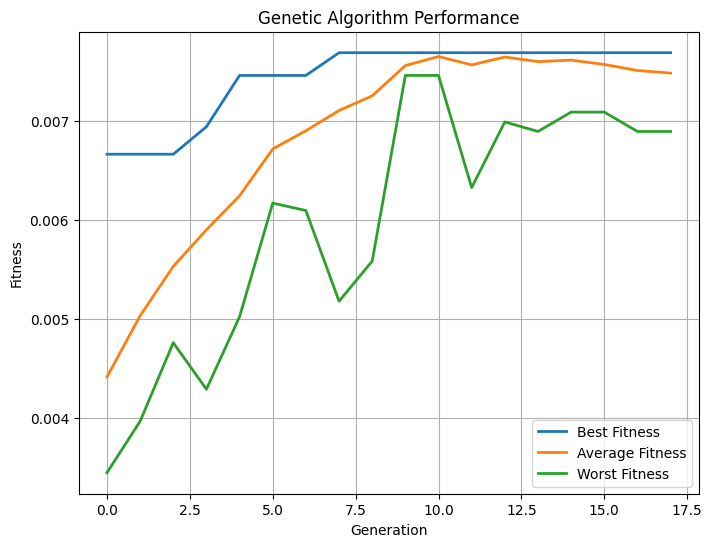

In [36]:
# Launch the GUI
launch_gui(genetic_algorithm, TEAMS, VENUES, DATES, MATCH_TIMES)


In [ ]:
## Cell 12: Multi-Experiment GUI (ipywidgets)

This section provides an interactive GUI using ipywidgets to configure and run multiple GA experiments with different parameter settings, enabling proper comparison between experiments.


In [ ]:
# ==================== MULTI-EXPERIMENT GUI WITH IPYWIDGETS ====================

# Global storage for experiment results
# Structure: {experiment_id: {'config': {...}, 'results': {...}, 'metrics': {...}}}
EXPERIMENT_STORAGE = {}

def create_experiment_config_widgets(exp_num):
    """
    Create widgets for configuring a single experiment.
    
    Parameters:
    -----------
    exp_num : int - Experiment number (1, 2, 3, ...)
    
    Returns:
    --------
    dict - Dictionary of widgets for this experiment
    """
    # Create a container for this experiment's widgets
    exp_widgets = {}
    
    # Experiment label
    exp_widgets['label'] = widgets.HTML(f"<h4>Experiment {exp_num}</h4>")
    
    # Population size widget
    exp_widgets['pop_size'] = widgets.IntSlider(
        value=50,
        min=10,
        max=200,
        step=10,
        description='Population:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Generations widget
    exp_widgets['generations'] = widgets.IntSlider(
        value=100,
        min=10,
        max=500,
        step=10,
        description='Generations:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Mutation rate widget
    exp_widgets['mutation_rate'] = widgets.FloatSlider(
        value=0.1,
        min=0.0,
        max=1.0,
        step=0.05,
        description='Mutation Rate:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Crossover rate widget
    exp_widgets['crossover_rate'] = widgets.FloatSlider(
        value=0.8,
        min=0.0,
        max=1.0,
        step=0.1,
        description='Crossover Rate:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Selection method widget
    exp_widgets['selection_method'] = widgets.Dropdown(
        options=['tournament', 'roulette'],
        value='tournament',
        description='Selection:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Crossover method widget
    exp_widgets['crossover_method'] = widgets.Dropdown(
        options=['one_point', 'two_point', 'order'],
        value='two_point',
        description='Crossover:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Elitism count widget
    exp_widgets['elitism_count'] = widgets.IntSlider(
        value=2,
        min=0,
        max=20,
        step=1,
        description='Elitism:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    return exp_widgets


def run_single_experiment(exp_id, config, teams, venues, dates, match_times):
    """
    Run a single GA experiment with given configuration.
    
    Parameters:
    -----------
    exp_id : str - Unique experiment identifier
    config : dict - GA parameter configuration
    teams, venues, dates, match_times : Tournament data
    
    Returns:
    --------
    dict - Experiment results including fitness history and final schedule
    """
    # Set random seed for reproducibility (using exp_id as part of seed)
    seed = hash(exp_id) % 10000
    random.seed(seed)
    np.random.seed(seed)
    
    # Run genetic algorithm
    results = genetic_algorithm(
        teams, venues, dates, match_times,
        pop_size=config['pop_size'],
        generations=config['generations'],
        crossover_rate=config['crossover_rate'],
        mutation_rate=config['mutation_rate'],
        elitism_count=config['elitism_count'],
        tournament_size=3,
        crossover_method=config['crossover_method'],
        mutation_method='swap',
        selection_method=config['selection_method']
    )
    
    # Calculate metrics
    initial_fitness = results['best_fitness_history'][0]
    final_fitness = results['best_fitness']
    improvement_pct = ((final_fitness - initial_fitness) / initial_fitness * 100) if initial_fitness > 0 else 0
    
    # Store experiment data
    experiment_data = {
        'config': config.copy(),
        'results': results,
        'metrics': {
            'initial_fitness': initial_fitness,
            'final_fitness': final_fitness,
            'improvement_pct': improvement_pct,
            'final_generation': results['final_generation'],
            'termination_reason': results['termination_reason']
        }
    }
    
    EXPERIMENT_STORAGE[exp_id] = experiment_data
    
    return experiment_data


def plot_individual_experiment(exp_id, experiment_data):
    """
    Generate individual plot for a single experiment.
    
    Parameters:
    -----------
    exp_id : str - Experiment identifier
    experiment_data : dict - Experiment results and configuration
    """
    results = experiment_data['results']
    config = experiment_data['config']
    
    plt.figure(figsize=(12, 6))
    
    generations = range(len(results['best_fitness_history']))
    
    # Plot best and average fitness
    plt.plot(generations, results['best_fitness_history'], 
             'b-', linewidth=2.5, label='Best Fitness', marker='o', markersize=4)
    plt.plot(generations, results['avg_fitness_history'], 
             'g--', linewidth=2, label='Average Fitness', marker='s', markersize=3)
    
    # Add configuration info to title
    title = f"Experiment {exp_id}\n"
    title += f"Pop={config['pop_size']}, Mut={config['mutation_rate']}, "
    title += f"Sel={config['selection_method']}, Cross={config['crossover_method']}, "
    title += f"Elite={config['elitism_count']}"
    
    plt.xlabel('Generation', fontsize=12, fontweight='bold')
    plt.ylabel('Fitness Value', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=11, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add metrics text
    metrics = experiment_data['metrics']
    textstr = f"Initial: {metrics['initial_fitness']:.6f}\n"
    textstr += f"Final: {metrics['final_fitness']:.6f}\n"
    textstr += f"Improvement: {metrics['improvement_pct']:.2f}%"
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()


def plot_comparative_experiments():
    """
    Generate a single comparison plot showing all experiments' best fitness curves.
    This plot directly supports discussion of parameter effects.
    """
    if len(EXPERIMENT_STORAGE) == 0:
        print("No experiments to compare. Please run experiments first.")
        return
    
    plt.figure(figsize=(14, 8))
    
    # Color palette for different experiments
    colors = plt.cm.tab10(np.linspace(0, 1, len(EXPERIMENT_STORAGE)))
    
    for i, (exp_id, exp_data) in enumerate(EXPERIMENT_STORAGE.items()):
        results = exp_data['results']
        config = exp_data['config']
        
        # Create label with key parameters
        label = f"Exp {exp_id}: "
        label += f"Pop={config['pop_size']}, "
        label += f"Mut={config['mutation_rate']}, "
        label += f"Sel={config['selection_method'][:3]}, "
        label += f"Cross={config['crossover_method'][:3]}, "
        label += f"Elite={config['elitism_count']}"
        
        generations = range(len(results['best_fitness_history']))
        plt.plot(generations, results['best_fitness_history'], 
                linewidth=2.5, label=label, marker='o', markersize=3, color=colors[i])
    
    plt.xlabel('Generation', fontsize=13, fontweight='bold')
    plt.ylabel('Best Fitness', fontsize=13, fontweight='bold')
    plt.title('Comparative Analysis: Best Fitness Evolution Across All Experiments', 
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=9, loc='best', ncol=1)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


def create_experiment_summary_table():
    """
    Create a pandas DataFrame summarizing all experiments for easy comparison.
    """
    if len(EXPERIMENT_STORAGE) == 0:
        print("No experiments to summarize.")
        return None
    
    summary_data = []
    
    for exp_id, exp_data in EXPERIMENT_STORAGE.items():
        config = exp_data['config']
        metrics = exp_data['metrics']
        
        summary_data.append({
            'Experiment': exp_id,
            'Population': config['pop_size'],
            'Mutation Rate': config['mutation_rate'],
            'Crossover Rate': config['crossover_rate'],
            'Selection': config['selection_method'],
            'Crossover': config['crossover_method'],
            'Elitism': config['elitism_count'],
            'Initial Fitness': metrics['initial_fitness'],
            'Final Fitness': metrics['final_fitness'],
            'Improvement %': metrics['improvement_pct'],
            'Final Gen': metrics['final_generation']
        })
    
    df = pd.DataFrame(summary_data)
    return df


# Main GUI function
def create_multi_experiment_gui(teams, venues, dates, match_times):
    """
    Create the main multi-experiment GUI using ipywidgets.
    
    This GUI allows users to:
    1. Specify number of experiments
    2. Configure parameters for each experiment
    3. Run all experiments sequentially
    4. View individual and comparative plots
    5. View summary table
    
    Parameters:
    -----------
    teams, venues, dates, match_times : Tournament data
    """
    # Output widget for displaying results
    output = Output()
    
    # Number of experiments selector
    num_experiments_widget = widgets.IntSlider(
        value=2,
        min=1,
        max=5,
        step=1,
        description='Number of Experiments:',
        style={'description_width': 'initial'}
    )
    
    # Container for experiment widgets
    experiments_container = widgets.VBox()
    
    # Store experiment widgets
    all_experiment_widgets = {}
    
    def update_experiment_widgets(change):
        """Update the number of experiment configuration panels"""
        num_exps = change['new']
        
        # Clear existing widgets
        all_experiment_widgets.clear()
        children = []
        
        # Create widgets for each experiment
        for i in range(1, num_exps + 1):
            exp_widgets = create_experiment_config_widgets(i)
            all_experiment_widgets[str(i)] = exp_widgets
            
            # Arrange widgets in a box
            exp_box = widgets.VBox([
                exp_widgets['label'],
                exp_widgets['pop_size'],
                exp_widgets['generations'],
                exp_widgets['mutation_rate'],
                exp_widgets['crossover_rate'],
                exp_widgets['selection_method'],
                exp_widgets['crossover_method'],
                exp_widgets['elitism_count']
            ], layout=Layout(border='2px solid gray', padding='10px', margin='5px'))
            
            children.append(exp_box)
        
        experiments_container.children = children
    
    # Initialize with default number
    update_experiment_widgets({'new': 2})
    num_experiments_widget.observe(update_experiment_widgets, names='value')
    
    # Run button
    run_button = widgets.Button(
        description='🚀 Run All Experiments',
        button_style='success',
        layout=Layout(width='200px', height='40px')
    )
    
    # Plot buttons
    plot_individual_button = widgets.Button(
        description='📊 Plot Individual Experiments',
        button_style='info',
        layout=Layout(width='200px', height='40px')
    )
    
    plot_comparative_button = widgets.Button(
        description='📈 Plot Comparative Analysis',
        button_style='warning',
        layout=Layout(width='200px', height='40px')
    )
    
    show_summary_button = widgets.Button(
        description='📋 Show Summary Table',
        button_style='',
        layout=Layout(width='200px', height='40px')
    )
    
    def on_run_clicked(b):
        """Handle run button click - execute all experiments"""
        with output:
            clear_output(wait=True)
            print("="*70)
            print("🚀 STARTING MULTI-EXPERIMENT EXECUTION")
            print("="*70)
            
            # Clear previous results
            EXPERIMENT_STORAGE.clear()
            
            # Run each experiment
            for exp_id, exp_widgets in all_experiment_widgets.items():
                print(f"\n{'='*70}")
                print(f"Running Experiment {exp_id}...")
                print(f"{'='*70}")
                
                # Extract configuration from widgets
                config = {
                    'pop_size': exp_widgets['pop_size'].value,
                    'generations': exp_widgets['generations'].value,
                    'mutation_rate': exp_widgets['mutation_rate'].value,
                    'crossover_rate': exp_widgets['crossover_rate'].value,
                    'selection_method': exp_widgets['selection_method'].value,
                    'crossover_method': exp_widgets['crossover_method'].value,
                    'elitism_count': exp_widgets['elitism_count'].value
                }
                
                # Run experiment
                exp_data = run_single_experiment(exp_id, config, teams, venues, dates, match_times)
                
                # Print summary
                metrics = exp_data['metrics']
                print(f"\n✅ Experiment {exp_id} completed:")
                print(f"   Initial Fitness: {metrics['initial_fitness']:.6f}")
                print(f"   Final Fitness: {metrics['final_fitness']:.6f}")
                print(f"   Improvement: {metrics['improvement_pct']:.2f}%")
                print(f"   Stopped at generation: {metrics['final_generation']}")
            
            print(f"\n{'='*70}")
            print("✅ ALL EXPERIMENTS COMPLETED!")
            print(f"   Total experiments: {len(EXPERIMENT_STORAGE)}")
            print(f"{'='*70}\n")
    
    def on_plot_individual_clicked(b):
        """Handle individual plot button click"""
        with output:
            clear_output(wait=True)
            if len(EXPERIMENT_STORAGE) == 0:
                print("No experiments to plot. Please run experiments first.")
            else:
                print("Generating individual experiment plots...\n")
                for exp_id, exp_data in EXPERIMENT_STORAGE.items():
                    plot_individual_experiment(exp_id, exp_data)
    
    def on_plot_comparative_clicked(b):
        """Handle comparative plot button click"""
        with output:
            clear_output(wait=True)
            if len(EXPERIMENT_STORAGE) == 0:
                print("No experiments to compare. Please run experiments first.")
            else:
                print("Generating comparative analysis plot...\n")
                plot_comparative_experiments()
    
    def on_show_summary_clicked(b):
        """Handle summary table button click"""
        with output:
            clear_output(wait=True)
            df = create_experiment_summary_table()
            if df is not None:
                print("="*100)
                print("📊 EXPERIMENT SUMMARY TABLE")
                print("="*100)
                print(df.to_string(index=False))
                print("="*100)
    
    # Attach button handlers
    run_button.on_click(on_run_clicked)
    plot_individual_button.on_click(on_plot_individual_clicked)
    plot_comparative_button.on_click(on_plot_comparative_clicked)
    show_summary_button.on_click(on_show_summary_clicked)
    
    # Arrange GUI layout
    controls = widgets.HBox([
        run_button,
        plot_individual_button,
        plot_comparative_button,
        show_summary_button
    ], layout=Layout(justify_content='center', margin='10px'))
    
    main_gui = widgets.VBox([
        widgets.HTML("<h2>🏆 Multi-Experiment GA Configuration</h2>"),
        num_experiments_widget,
        widgets.HTML("<h3>Experiment Configurations:</h3>"),
        experiments_container,
        controls,
        output
    ])
    
    return main_gui


print("✅ Multi-Experiment GUI functions loaded!")
print("   Use: gui = create_multi_experiment_gui(TEAMS, VENUES, DATES, MATCH_TIMES)")
print("   Then: display(gui)")


In [ ]:
### Launch Multi-Experiment GUI

Run this cell to display the interactive GUI for configuring and running multiple experiments.


In [ ]:
# Launch the Multi-Experiment GUI
multi_exp_gui = create_multi_experiment_gui(TEAMS, VENUES, DATES, MATCH_TIMES)
display(multi_exp_gui)
